## Lab 1 - A-star

Implement the A* to the set cover problem

In [10]:
import numpy as np
from random import random
from functools import reduce
import queue
import matplotlib.pyplot as plt
from collections import namedtuple
import scipy
from math import factorial
from tqdm import tqdm

In [11]:
PROBLEM_SIZE = 25
NUM_SETS = 64
State = namedtuple('state', ['taken', 'not_taken'])
SETS = tuple(np.array([random() < .5 for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))

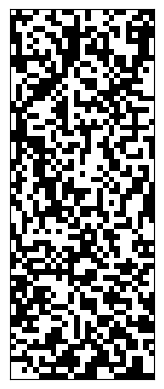

In [12]:
def draw_sol(map):
    plt.imshow(map, cmap="binary")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show();

draw_sol(np.vstack([SETS[i] for i in range(NUM_SETS)]))

In [13]:
def draw_plots(size, plots, xlabel="x", ylabel="y", legend_title=" "):
    for label in plots.keys():
        plt.plot(range(1, size), plots[label], label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, size))
    plt.legend(title=legend_title)
    plt.show()

In [14]:
def goal_check(state): # function to check if we found a set cover
    return len(state.taken) > 0 and np.all(reduce(np.logical_or, [SETS[i] for i in state.taken])) 

assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable" # check if the problem is solvable

In [15]:
def heur1(state):
    return PROBLEM_SIZE - np.sum(reduce(np.logical_or, [SETS[i] for i in state.taken], [False for _ in range(PROBLEM_SIZE)]))

In [16]:
def find_solution(f = lambda s: len(s.taken), verbose=True, ubound=10000): #f is the function that calculates the cost of reaching a state
    frontier = queue.PriorityQueue()
    frontier.put((0, State(set(), set(range(NUM_SETS)))))  #initial state
    _, curr_state = frontier.get()
    counter = 0
    while not goal_check(curr_state):
        counter += 1
        if verbose:
            print(counter)
        if ubound and ubound < counter:
            del frontier
            print("Computation timed out")
            return -1, counter
        for action in curr_state.not_taken:
            new_state = State(curr_state.taken ^ {action}, curr_state.not_taken ^ {action}) #using XOR for both operations
            frontier.put((f(new_state), new_state))
        _, curr_state = frontier.get()
    if verbose:
        print("Found solution", curr_state.taken ,"in", counter, "steps.\nCost:", len(curr_state.taken))
        draw_sol(np.vstack([SETS[i] for i in curr_state.taken]))
    del frontier
    return len(curr_state.taken), counter

Let's calculate solutions with breadth-first and greedy best-first algorithms to use them as a benchmark:

## Breadth First


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


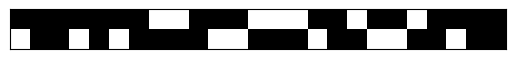

In [17]:
bf_cost, bf_steps = find_solution()

## Greedy Best First

1
2
Found solution {8, 12} in 2 steps.
Cost: 2


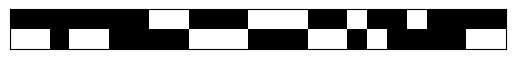

In [18]:
gbf_cost, gbf_steps = find_solution(heur1)

# A*

The metric used to calculate the priority is

    f(n) = g(n) + h(n)

- g is the cost
- h is the heuristic (distance)

## First approach

- g = number of sets taken
- h = number of spots left to fill

1
2
Found solution {8, 12} in 2 steps.
Cost: 2


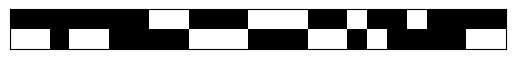

In [19]:
curr_cost, curr_steps = find_solution(lambda s: heur1(s) + len(s.taken))

### Observations:
The first approach doesn't provide any improvement when compared to greedy best first.

## Adding a weight to g(n)
Let's try adding a weight to each edge traversed.

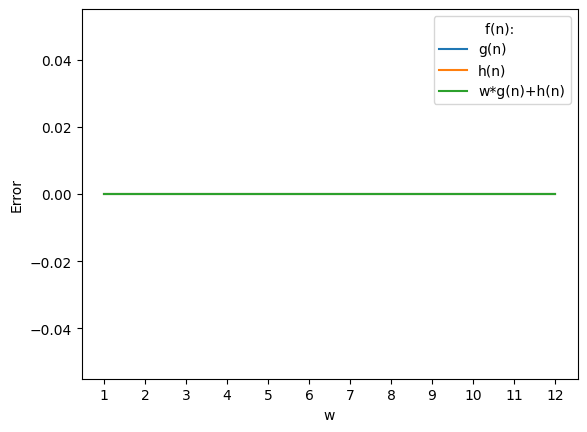

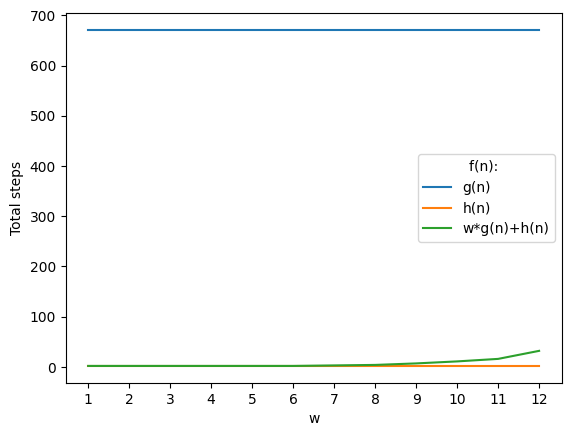

In [20]:
w = 1
costs = []
steps = []
costs.append(curr_cost - bf_cost)
steps.append(curr_steps)
for w in range(1, int(0.5 * PROBLEM_SIZE)):
            w += 1
            curr_cost, curr_steps = find_solution(lambda s: heur1(s) + w * len(s.taken), verbose=False)
            costs.append(curr_cost - bf_cost)
            steps.append(curr_steps)

draw_plots(w+1, plots={
    "g(n)": [0 for _ in range(1, w+1)],
    "h(n)": [gbf_cost - bf_cost for _ in range(1, w+1)],
    "w*g(n)+h(n)": costs
    },
    xlabel="w",
    ylabel="Error",
    legend_title="f(n): ")

draw_plots(w+1, plots={
    "g(n)": [bf_steps for _ in range(1, w+1)],
    "h(n)": [gbf_steps for _ in range(1, w+1)],
    "w*g(n)+h(n)": steps
    },
    xlabel="w",
    ylabel="Total steps",
    legend_title="f(n): ")

### Observations
Predictably, as w increases, the algorithm behaves more like uniform-cost search (becomes slower), however it reaches an optimal solution with relatively low values of w.

## Changing heuristics
Let's try changing h(n) to penalize repeated values

In [21]:
def heur2(state):
    mask = [0.5 if e > 1 else e for e in np.sum([SETS[i].astype(int) for i in state.taken], axis=0)]
    return PROBLEM_SIZE - np.sum(mask)

1
2
Found solution {8, 12} in 2 steps.
Cost: 2


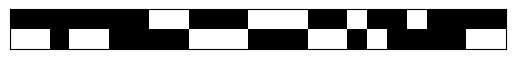

In [22]:
gbf_norep_cost, gbf_norep_steps = find_solution(heur2)

1
2
3
4
5
6
7
8
9
10
11
Found solution {8, 12} in 11 steps.
Cost: 2


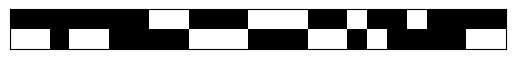

In [23]:
w = 0.5 * PROBLEM_SIZE/2
a_norep_cost, a_norep_steps = find_solution(lambda s: w * len(s.taken) + heur2(s))

Let's compare the results

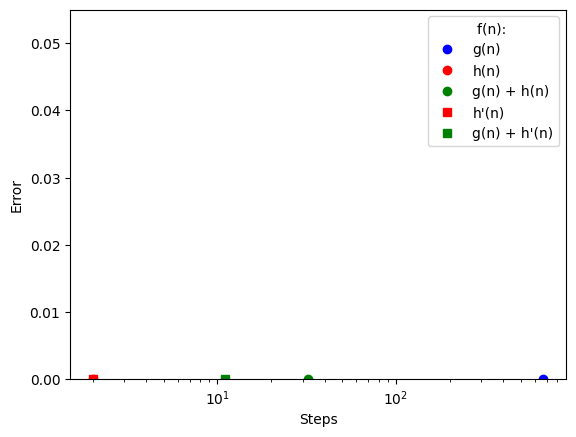

In [24]:
plt.plot(bf_steps, 0, 'bo', label="g(n)")
plt.plot(gbf_steps, gbf_cost - bf_cost, 'ro', label="h(n)")
plt.plot(steps[-1], costs[-1], 'go', label="g(n) + h(n)")
plt.plot(gbf_norep_steps, gbf_norep_cost - bf_cost, 'rs', label="h'(n)")
plt.plot(a_norep_steps, a_norep_cost - bf_cost, 'gs', label="g(n) + h'(n)")
plt.xlabel("Steps")
plt.ylabel("Error")
plt.legend(title="f(n): ")
ax = plt.gca()
ax.set_xscale('log')
ax.set_ybound(0.)
plt.show();

The results given by the second heuristic are comparable to those of the first.

### Approximating BFS

Up until now, we used BFS to calculate the optimal solution.
This works for small problems, but it becomes unfeasible for larger ones.
We can approximate the results of BFS by using linear programming to find an optimal solution, then calculate how much time it would have taken BFS to find that solution.

In [25]:
def approx_BFS():
    def BFS_steps(depth):  # calculates the number of steps taken by BFS to find a solution at given depth in the worst-case scenario
        steps = 0
        for d in range(1, depth+1):
            steps += factorial(NUM_SETS) / factorial(NUM_SETS - d)
        return steps
    objective = np.array([1 for _ in range(NUM_SETS)])
    constraint_mat = np.vstack((np.vstack([SETS[i].astype(int) * -1 for i in range(NUM_SETS)]).T, np.eye(NUM_SETS), np.eye(NUM_SETS) * -1))
    constraint_vec = np.hstack((np.array([-1 for _ in range(PROBLEM_SIZE)]), np.array([1 for _ in range(NUM_SETS)]), np.array([0 for _ in range(NUM_SETS)])))
    sol = np.where(scipy.optimize.linprog(objective, constraint_mat, constraint_vec, bounds=(0, 1), integrality=1).x>0.5)
    return set(sol[0]), int(BFS_steps(len(sol[0])))

In [26]:
def draw_points(P, *args):
    plt.title("Path searching algorithm performance with p = {}".format(P))
    plt.plot(args[0], args[1], 'ro', label="h(n)", alpha=0.2)
    plt.plot(args[2], args[3], 'go', label="{}g(n) + h(n)".format(P * PROBLEM_SIZE/4), alpha=0.2)
    plt.plot(args[4], args[5], 'ms', label="h'(n)", alpha=0.2)
    plt.plot(args[6], args[7], 'ys', label="{}g(n) + h'(n)".format(P * PROBLEM_SIZE/4), alpha=0.2)
    plt.xlabel("Steps")
    plt.ylabel("Error")
    plt.legend(title="f(n): ")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_ybound(0.)
    plt.show()

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


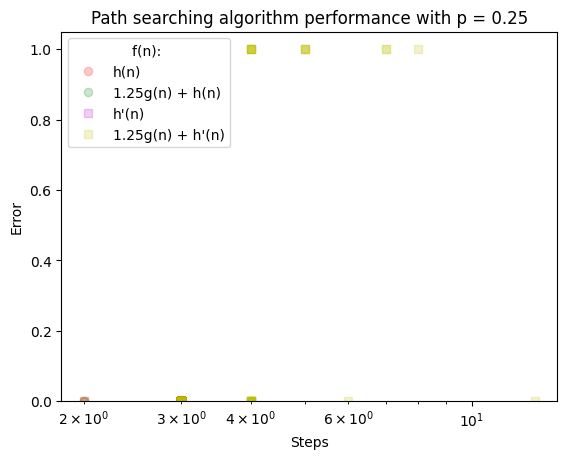

 18%|█▊        | 18/100 [00:08<00:42,  1.93it/s]

In [27]:
NUM_SETS = 512
PROBLEM_SIZE = 20
for P in (0.25, 0.5, 0.75):
    gbf1_s = []
    gbf1_c = []
    a1_s = []
    a1_c = []
    gbf2_s = []
    gbf2_c = []
    a2_s = []
    a2_c = []
    for _ in tqdm(range(100)):
        SETS = tuple(np.array([random() < P for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))
        assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable"
        aBFS_sol, _ = approx_BFS()
        bfs_cost = len(aBFS_sol)
        gbf1_cost, gbf1_steps = find_solution(heur1, verbose=False)
        if gbf1_cost > -1:
            gbf1_s.append(gbf1_steps)
            gbf1_c.append(gbf1_cost - bfs_cost)
        gbf2_cost, gbf2_steps = find_solution(heur2, verbose=False)
        if gbf2_cost > -1:
            gbf2_s.append(gbf1_steps)
            gbf2_c.append(gbf1_cost - bfs_cost)
        a1_cost, a1_steps = find_solution(lambda s: P * PROBLEM_SIZE/4 * len(s.taken) + heur1(s), verbose= P == 0.75)
        if a1_cost > -1:
            a1_c.append(a1_cost - bfs_cost)
            a1_s.append(a1_steps)
        a2_cost, a2_steps = find_solution(lambda s: P * PROBLEM_SIZE/4 * len(s.taken) + heur2(s), verbose= P == 0.75)
        if a2_cost > -1:
            a2_c.append(a2_cost - bfs_cost)
            a2_s.append(a2_steps)    
    draw_points(P, gbf1_s, gbf1_c, a1_s, a1_c, gbf2_s, gbf2_c, a2_s, a2_c)